In [1]:
import pandas as pd
import numpy as np
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import time
from tqdm import tqdm

filepath = 'WikiQACorpus/'

In [2]:
# Load the dataset
train_tsv = pd.read_csv(filepath + 'WikiQA-train.tsv', sep='\t')
train_tsv['Text'] = train_tsv.apply(lambda row: f"{row['Question']} {row['Sentence']}", axis=1) # Concatenate Qs and As
text_corpus = ' '.join(train_tsv['Text'])

# Use the basic whitespace tokenizer
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer(text_corpus)
tokens = tokens[:100000]
print(len(tokens))

# Build a vocabulary from the tokens
token_counts = Counter(tokens)
vocab_obj = vocab(token_counts, specials=["<unk>", "<pad>"])
vocab_obj.set_default_index(vocab_obj["<unk>"])  # Set default index for unknown tokens
numericalized_tokens = [vocab_obj[token] for token in tokens]

100000


In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(1, max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(0).unsqueeze(2)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :] # x shape: [batch_size, seq_len, d_model]

In [4]:
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Create transformer decoder layers
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        self.output_layer = nn.Linear(d_model, vocab_size)

        # Enable attention weight output
        for layer in self.transformer_decoder.layers:
            layer.self_attn.need_weights = True
        
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.output_layer.bias.data.zero_()
        self.output_layer.weight.data.uniform_(-initrange, initrange)
    
    def forward(self, src, return_attn=False):
        # src shape: [batch_size, seq_len]
        
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(src.size(1)).to(src.device)
        
        # Embed and apply positional encoding
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)

        # output = self.transformer_decoder(src, src, tgt_mask=tgt_mask)
        # attn_weights = [layer.self_attn.get_weights() for layer in self.transformer_decoder.layers]
        
        attn_weights = []
        x = src
        for layer in self.transformer_decoder.layers:
            x = layer.norm1(x + layer.dropout1(layer.self_attn(x, x, x, attn_mask=tgt_mask, need_weights=True)[0]))
            attn_weights.append(layer.self_attn(x, x, x, need_weights=True)[1])

        # Transform
        output = self.output_layer(x)
        return (output, attn_weights) if return_attn else output

In [5]:
class TextDataset(Dataset):
    def __init__(self, tokens, seq_length):
        self.tokens = tokens
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.tokens) - self.seq_length
        
    def __getitem__(self, idx):
        input_seq = self.tokens[idx:idx + self.seq_length]
        target_seq = self.tokens[idx + 1:idx + self.seq_length + 1]
        return torch.tensor(input_seq), torch.tensor(target_seq)

In [6]:
import matplotlib.pyplot as plt
import os

def visualize_attention(epoch, attn_weights, save_dir="attention_visuals"):
    os.makedirs(save_dir, exist_ok=True)
    num_layers = len(attn_weights)
    
    for layer_idx, layer_weights in enumerate(attn_weights):
        # layer_weights shape: [batch_size, num_heads, seq_len, seq_len]
        for head_idx, head_weights in enumerate(layer_weights[0]):  # Select first sample in batch
            plt.figure(figsize=(8, 8))
            plt.imshow(head_weights.detach().cpu().numpy(), cmap="viridis")
            plt.colorbar()
            plt.title(f"Epoch {epoch + 1} - Layer {layer_idx + 1}, Head {head_idx + 1}")
            plt.xlabel("Key Sequence")
            plt.ylabel("Query Sequence")
            plt.savefig(f"{save_dir}/epoch{epoch + 1}_layer{layer_idx + 1}_head{head_idx + 1}.png")
            plt.close()

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()
    total_batches = len(train_loader)
    history = {
        'train_loss': [], 'train_perplexity': [], 
        'val_loss': [], 'val_perplexity': [], 
        'attn_weights': []
    }

    def evaluate():
        model.eval()
        val_losses = []
        val_perplexities = []
        
        with torch.no_grad():
            with tqdm(total=len(val_loader), desc='Validation', unit='batch') as pbar:
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    output = output.view(-1, output.size(-1))
                    target = target.view(-1)
                    
                    loss = criterion(output, target).item()
                    perplexity = math.exp(loss)
                    
                    val_losses.append(loss)
                    val_perplexities.append(perplexity)
                    
                    pbar.set_postfix(loss=f'{loss:.4f}', perplexity=f'{perplexity:.2f}')
                    pbar.update(1)
        
        return np.mean(val_losses), np.mean(val_perplexities)

    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        epoch_perplexities = []

        with tqdm(total=total_batches, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                
                optimizer.zero_grad()
                output, attn_weights = model(data, return_attn=True)
                
                # Reshape output and target for cross-entropy loss
                output = output.view(-1, output.size(-1))
                target = target.view(-1)
                
                loss = criterion(output, target)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                optimizer.step()
                
                #Calculate batch metrics
                batch_loss = loss.item()
                batch_perplexity = math.exp(batch_loss)

                epoch_losses.append(batch_loss)
                epoch_perplexities.append(batch_perplexity)

                pbar.set_postfix(loss=f'{batch_loss:.4f}', perplexity=f'{batch_perplexity:.2f}')
                pbar.update(1)
                
        # Run Validation
        val_loss, val_perplexity = evaluate()

        # Calculate epoch metrics
        train_loss = np.mean(epoch_losses)
        train_perplexity = np.mean(epoch_perplexities)
        # epoch_time = time.time() - start_time

        history['train_loss'].append(train_loss)
        history['train_perplexity'].append(train_perplexity)
        history['val_loss'].append(val_loss)
        history['val_perplexity'].append(val_perplexity)
        history['attn_weights'].append(attn_weights)

        print(f'\nEpoch {epoch + 1} Summary:')
        print(f'Train Loss: {train_loss:.4f}, Train Perplexity: {train_perplexity:.2f}')
        print(f'Val Loss: {val_loss:.4f}, Val Perplexity: {val_perplexity:.2f}\n')

    return history

In [ ]:
# Hyperparameters
BATCH_SIZE = 64
SEQ_LENGTH = 32
LEARNING_RATE = 0.0001

# Create dataset and split into train/val
dataset = TextDataset(numericalized_tokens, SEQ_LENGTH)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Initialize model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerLanguageModel(len(vocab_obj), num_layers=4).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, device)

#Save the model and history
torch.save(model.state_dict(), 'q3_LM.pt')
with open('q3_history.pkl', 'wb') as f:
    import pickle
    pickle.dump(history, f)




Validation: 100%|██████████| 313/313 [00:50<00:00,  6.22batch/s, loss=2.0526, perplexity=7.79]



Epoch 1 Summary:
Train Loss: 4.1472, Train Perplexity: 292.71
Val Loss: 2.0805, Val Perplexity: 8.02



Validation: 100%|██████████| 313/313 [00:50<00:00,  6.24batch/s, loss=0.5598, perplexity=1.75]



Epoch 2 Summary:
Train Loss: 1.2596, Train Perplexity: 3.88
Val Loss: 0.5543, Val Perplexity: 1.74



Validation: 100%|██████████| 313/313 [00:53<00:00,  5.88batch/s, loss=0.3538, perplexity=1.42]



Epoch 3 Summary:
Train Loss: 0.4820, Train Perplexity: 1.62
Val Loss: 0.3358, Val Perplexity: 1.40



Validation: 100%|██████████| 313/313 [00:53<00:00,  5.89batch/s, loss=0.2965, perplexity=1.35]



Epoch 4 Summary:
Train Loss: 0.3344, Train Perplexity: 1.40
Val Loss: 0.2899, Val Perplexity: 1.34



Validation: 100%|██████████| 313/313 [00:52<00:00,  5.92batch/s, loss=0.2944, perplexity=1.34]



Epoch 5 Summary:
Train Loss: 0.2832, Train Perplexity: 1.33
Val Loss: 0.2723, Val Perplexity: 1.31



Validation: 100%|██████████| 313/313 [00:52<00:00,  5.92batch/s, loss=0.2847, perplexity=1.33]



Epoch 6 Summary:
Train Loss: 0.2569, Train Perplexity: 1.29
Val Loss: 0.2642, Val Perplexity: 1.30



Validation: 100%|██████████| 313/313 [00:52<00:00,  5.92batch/s, loss=0.2716, perplexity=1.31]



Epoch 7 Summary:
Train Loss: 0.2412, Train Perplexity: 1.27
Val Loss: 0.2606, Val Perplexity: 1.30



Validation: 100%|██████████| 313/313 [00:53<00:00,  5.86batch/s, loss=0.2791, perplexity=1.32]



Epoch 8 Summary:
Train Loss: 0.2310, Train Perplexity: 1.26
Val Loss: 0.2594, Val Perplexity: 1.30



Validation: 100%|██████████| 313/313 [00:52<00:00,  5.93batch/s, loss=0.2821, perplexity=1.33]



Epoch 9 Summary:
Train Loss: 0.2237, Train Perplexity: 1.25
Val Loss: 0.2584, Val Perplexity: 1.30



Validation: 100%|██████████| 313/313 [00:51<00:00,  6.05batch/s, loss=0.2773, perplexity=1.32]



Epoch 10 Summary:
Train Loss: 0.2180, Train Perplexity: 1.24
Val Loss: 0.2574, Val Perplexity: 1.29



AttributeError: module 'pickle' has no attribute 'dumpe'

In [ ]:
def generate_text(model, tokenizer, vocab_obj, seed_text, max_length=50, temperature=1.0, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Tokenize the seed text and convert to numericalized tokens
        tokens = tokenizer(seed_text)
        token_ids = torch.tensor([vocab_obj[token] for token in tokens], dtype=torch.long).unsqueeze(0).to(device)
        
        # Generate text iteratively
        for _ in range(max_length):
            # Pass the token_ids through the model
            output = model(token_ids, return_attn=False)  # Ignore attention weights
            logits = output[:, -1, :]  # Focus on the last token's predictions
            
            # Apply temperature scaling to logits
            logits = logits / temperature
            
            # Convert logits to probabilities using softmax
            probabilities = F.softmax(logits, dim=-1).squeeze()
            
            # Sample the next token from the probability distribution
            next_token_id = torch.multinomial(probabilities, num_samples=1).item()
            
            # Break if the sampled token is the <pad> or <unk> token
            if next_token_id == vocab_obj['<pad>'] or next_token_id == vocab_obj['<unk>']:
                break
            
            # Append the next token to the sequence
            token_ids = torch.cat([token_ids, torch.tensor([[next_token_id]], device=device)], dim=1)
        
        # Convert token IDs back to text
        generated_tokens = [vocab_obj.lookup_token(token_id) for token_id in token_ids.squeeze().tolist()]
        return ' '.join(generated_tokens)



In [93]:
model = TransformerLanguageModel(len(vocab_obj), num_layers=4).to(device)
model.load_state_dict(torch.load('q3_LM.pt'))
model.eval()

# Example usage
seed_text = "Canada is known for"
generated_text = generate_text(model, tokenizer, vocab_obj, seed_text, max_length=20, temperature=0.8, device=device)
print(f"Seed Text: {seed_text}")
print(f"Generated Text: {generated_text}")


Seed Text: Canada is known for
Generated Text: canada is known for its september celebrations , and is the birthplace of chewing gum and punta rock . how many stars on the


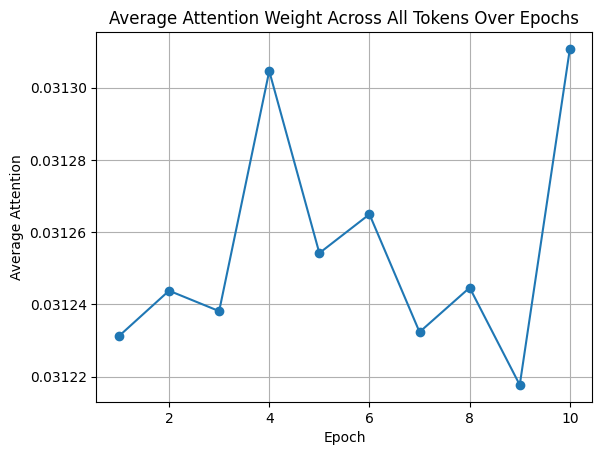

In [39]:
with open('q3_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot example attention weights (e.g., for the last epoch)
import matplotlib.pyplot as plt

avg_attention_per_epoch = []
for epoch_attn in history['attn_weights']:
    epoch_avg = []
    for layer in epoch_attn:
        if isinstance(layer, list) or isinstance(layer, tuple):
            layer_avg = torch.stack(layer).mean(dim=0)  # Average over heads
        else:
            layer_avg = layer.mean(dim=0)  # Already a single tensor

        epoch_avg.append(layer_avg.mean().item())  # Average over all tokens
    avg_attention_per_epoch.append(np.mean(epoch_avg))

# Plot average attention over epochs
plt.plot(range(1, len(avg_attention_per_epoch) + 1), avg_attention_per_epoch, marker='o')
plt.title("Average Attention Weight Across All Tokens Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Attention")
plt.grid()
plt.show()


